In [1]:
# preliminaries: let's load some stuff
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import AxesImage
import seaborn as sns
sns.set_context('talk')

from matplotlib import animation, rc
from IPython.display import HTML

np.random.seed(12345)

# More than a sum of parts: network computing with neurons

One of the most important ideas in theoretical neuroscience is the (surprising) finding that brains are more than just a collection of the computations performed by individual neurons. This is partly because the properties we think of as "single neuron" computations are often the byproduct of network effects. But it is also reflective of a deeper truth: **nonlinearity and recurrence** unlock powerful computational capabilities in networks.  

Let's unpack that a bit. 

## Linearity and its discontents

First off, **nonlinearity** describes any phenomenon which is, well, _not linear_. So what does linear mean? Mostly this: if we make the input to a system twice as strong, the response of the system will scale in proportion. So, if we're thinking of input-ouput functions of neurons, we'd get something like:

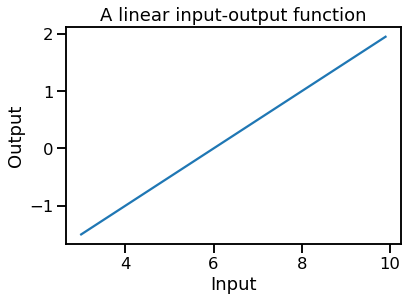

In [2]:
input_range = np.arange(3, 10, 0.1)
plt.plot(input_range, 0.5 * input_range - 3)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('A linear input-output function');

So far so good. But as we know, _neurons_ don't have negative outputs. Their input-output functions look more like this:

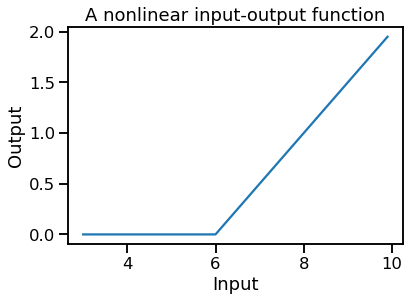

In [3]:
plt.plot(input_range, np.maximum(0.5 * input_range - 3, 0))
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('A nonlinear input-output function');

Notice something really interesting: Even though this function is linear for inputs > 6, it is _nonlinear_ over all. It's a very, very mild nonlinearity, but that's enough for fascinating things to happen. 

In the next section, we'll discuss why.

## Composition and recurrence

One of the mathematically nicest but also most limiting features of linear systems is that when we **compose** linear systems (feeding the output of one into another), _they remain linear_. Using lots of linear building blocks in sequence doesn't really buy us more than having one giant linear system.

![boring](https://media1.tenor.com/images/b278a5a006340b8946457552adec56c5/tenor.gif?itemid=7991240)

But when we compose nonlinear systems, all sorts of things can happen. In fact, if we take three sets of neurons &mdash; an input layer, a middle (often called hidden) layer, and an output layer &mdash; this is enough to approximate **any** function.

![title](http://www.quickmeme.com/img/a7/a78ae76da19c1a0f9e0e9b2f7e6229e70bd36cf7bc5b2f29b5f8900face50234.jpg)

But there's another idea we might have: what if we feed the output of a system (linear or nonlinear) _back into itself_? We call that idea **recurrence**, and it's also incredibly powerful. In fact, recurrent linear systems do some pretty cool things, but recurrent nonlinear systems have can have really, really complex behavior.

![nonlinear-brain](https://i.imgflip.com/49k332.jpg)

The rest of this section is about exploring how nonlinearity and recurrence can work together to do something that no collection of isolated neurons can do.

## Hopfield networks

One of the most influential examples of how nonlinearity and recurrence can work together to perform interesting computations was given by John Hopfield in his [seminal 1982 PNAS paper](https://www.pnas.org/content/pnas/79/8/2554.full.pdf) (cited over 20,000 times!). In a nutshell, what Hopfield showed was that collections of neurons with nonlinear interactions could create dynamics that resulted in new kinds of collective behavior. In particular, he applied these ideas to provide a new model of associative memory we'll explore below.

Like most models in neuroscience, Hopfield's model makes a number of simplifications &mdash; it's not a simulator. Rather, in theoretical neuroscience, the key question is often how to capture _just enough_ to detail to illustrate a concept while keeping the math tractable.

Our treatment is based on Hopfield's own very readable review [here](http://scholarpedia.org/article/Hopfield_network). All the code is below, but we'll focus on concepts.

### Just enough math

![just enough math](https://i.imgflip.com/49k541.jpg)

So here goes:

Take a bunch of neurons. Let's index them with $j = 1\ldots N$.

Let the activity of neuron $j$ be $V_j$. (This would normally be the membrane voltage. Since we have one per neuron, it's a vector.)

Let the connection strength _from_ neuron $k$ _to_ neuron $j$ be $T_{jk}$. (These form a matrix of synaptic strengths.)

Let's assume every neuron is also getting some input $I_j$. (These would be external currents (also a vector).)

**Now here's how it behaves:**

1. Figure out the _total input_ to each neuron: $x_j = I_j + \sum_k T_{jk} V_k$ (or, if you like linear algebra, $\mathbf{x} = \mathbf{T V + I}$). 
2. Each neuron has a nonlinear response: set $V_j = 1$ if $x_j > 0$ and $V_j = 0$ if $x_j < 0$.
3. Repeat. 

Note that this process is nonlinear (from step 2) and recurrent (from steps 1 and 3). Because each neuron's $V$ keeps changing, the inputs to its connections keep changing, and that will lead to interesting dynamics.

**This raises two important questions:**

1. Does the system ever settle down?
1. Can we use these dynamics to do something interesting?

The answer to both questions is **yes**, and for fascinating reasons. 

For the **first question**, it's that the system has something called a Lyapunov function, which is something like an energy that always decreases over time. And this function has a minimum (under certain mathematical conditions). In these cases, the system is guaranteed to settle down.

As for the **second question**, 

![magic](https://i.giphy.com/media/3o7TKP9ln2Dr6ze6f6/giphy.webp)

## Implementing the Hopfield network

We'll start by selecting some patterns for the network to remember.

One of the important points here is that these patterns can't be just anything. They have to be approximately "non-overlapping" (orthogonal) for the following to work.

Here, we'll choose a particularly simple form for these patterns: horizontal and vertical stripes.

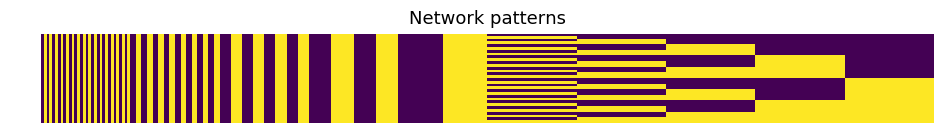

In [4]:
Npat = 10  # number of patterns
Ndim = 32  # each pattern will be an image Ndim x Ndim

patterns = np.empty((Npat, Ndim**2))

for ii in range(Npat):
    patterns[ii] = np.mod((np.arange(Ndim**2) // 2**ii), 2)

plt.matshow(np.concatenate(patterns.reshape((-1, Ndim, Ndim)), axis=1))
plt.title('Network patterns')
plt.axis('off');

Define a connection matrix according to a formula in Hopfield's original paper:

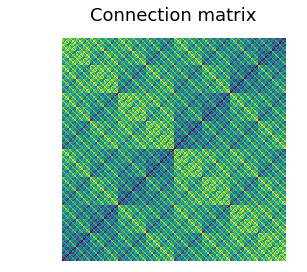

In [5]:
T = (2 * patterns - 1).T @ (2 * patterns - 1)
np.fill_diagonal(T, 0)
plt.matshow(T)
plt.title('Connection matrix')
plt.axis('off');

And if we check the dot products of the patterns against each other, we can see that they're orthogonal:

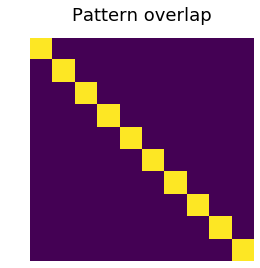

In [6]:
plt.matshow((2 * patterns - 1) @ (2 * patterns - 1).T)
plt.title('Pattern overlap')
plt.axis('off');

Define a function to evolve the network one time step:

In [7]:
def evolve(V, T, I):
    return T @ V + I > 0

### Experiment 1: stable states

Pick a random starting pattern to initialize the network to.

(Each time you run this cell, you'll get a new pattern.)

And let's see what happens when we let the network evolve:

(The following function animates the network's evolution based on [this blog post](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/).)

In [8]:
def plot_network(Vinit, Nframes=100):
    img = plt.matshow(Vinit.reshape((Ndim, Ndim)))
    plt.axis('off');
    
    def evolver(Vinit):
        v = Vinit
        yield np.zeros(v.shape)
        yield v
        for _ in range(Nframes):
            v = evolve(v, T, I)
            yield v
    
    # animation function. This is called sequentially
    def animate(v):
        img.set_data(v.reshape((Ndim, Ndim)))
        return (img,)
    
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(img.figure, animate, 
                                   frames=evolver(Vinit.copy()), interval=200)

    return HTML(anim.to_jshtml())

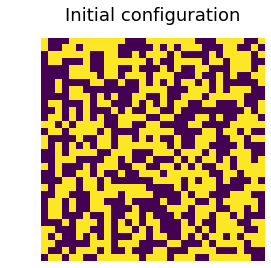

In [9]:
V = np.random.rand(Ndim**2) > 0.5
I = 0

ax = plt.matshow(V.reshape((Ndim, Ndim)))
plt.title('Initial configuration')
plt.axis('off');

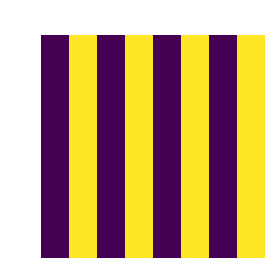

In [10]:
plot_network(V, 20)

Try running the above cells a few times.

Can you think of a reason why not all initial configurations evolve into one of the "memorized" patterns?

### Experiment 2: noise corruption

Let's corrupt one of the patterns with some random bit noise and see what the network does with it.

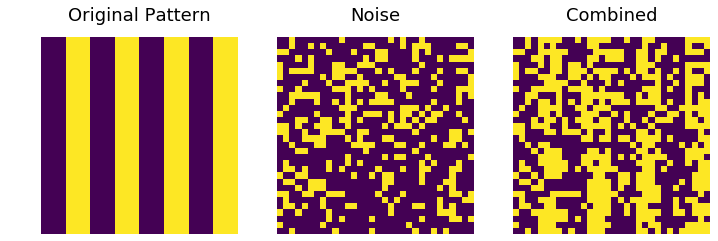

In [11]:
Vinit = patterns[2]

fraction_flips = 0.3
noise = np.random.rand(*V.shape) <= fraction_flips
V = np.logical_xor(Vinit, noise)
I = 0

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes[0].matshow(Vinit.reshape((Ndim, Ndim)))
axes[0].set_title('Original Pattern')
axes[0].axis('off');

axes[1].matshow(noise.reshape((Ndim, Ndim)))
axes[1].set_title('Noise')
axes[1].axis('off');

axes[2].matshow(V.reshape((Ndim, Ndim)))
axes[2].set_title('Combined')
axes[2].axis('off');

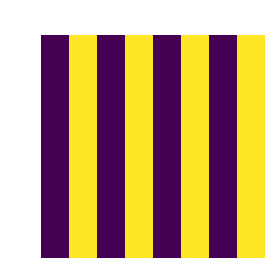

In [12]:
plot_network(V, 20)

Try running this a few times with different patterns. How does the parameter `fraction_flips` (the fraction of bits that are corrupted in the initial pattern) affect recovery?

## Big questions to ponder

1. How might a network like this be used by brains?
1. How could it be learned?
1. How could you test the hypothesis that a specific circuit(s) implemented a Hopfield-like network?